In [4]:
import sys
import os
ROOT_PATH = os.path.dirname(os.getcwd())
sys.path.append(ROOT_PATH)

from data_preparation.word_difficulty_dataset_generator import WordDifficultyData
from data_preparation.cefr import num_to_cefr
from common.wdd_manager import WDDManager
import matplotlib.pyplot as plt
import numpy as np

In [5]:
wdds_path = "../data/wdds" # Path to folder containing data sets

Get TF and TF-IDF data sets.   
As mentioned in the paper, TF-IDF valuees has an issue where a word in all subreddits and a word not in a subreddit will both have a value of zero

In [6]:
wdd_manager = WDDManager(wdds_path)
wdd_tf_idf = wdd_manager.get_wdd(data_type="tf_idf")
wdd_tf = wdd_manager.get_wdd(data_type="tf")

loading tf_idf, no change...
Done!
loading tf, no change...
Done!


Get the number of unique words in each document

In [7]:
def num_docs_per_word(wdd):
    data = wdd.features()
    num_words_n_docs = {}
    for index, row in data.iterrows():
        summation = sum((row != 0.0) *1)
        if summation not in num_words_n_docs:
            num_words_n_docs[summation] = 1
        else:
            num_words_n_docs[summation] += 1
            
    if 0 not in num_words_n_docs:
        num_words_n_docs[0] = 0

    return num_words_n_docs

Get the number of unique Oxford 5000 words in each document grouped by CEFR levels from [A1, C]

In [8]:
def level_num_docs_per_word(wdd):
    data = wdd.features()
    scores = wdd.output()
    
    levels_num_words_n_docs = [{} for _ in range(5)]
    for (index, row), score in zip(data.iterrows(), scores):
        summation = sum((row != 0.0) *1)
        if summation not in levels_num_words_n_docs[score]:
            levels_num_words_n_docs[score][summation] = 1
        else:
            levels_num_words_n_docs[score][summation] += 1
        
    for score in range(5):
        if 0 not in levels_num_words_n_docs[score]:
            levels_num_words_n_docs[score][0] = 0
    
    return levels_num_words_n_docs

Get the CEFR level distribution of Oxford 5000 words for each CEFR level in every subreddit

In [9]:
def level_frequecy(wdd, features=None):
    if features is None:
        features = wdd.features()
    scores = wdd.output()
    
    total_freqs = {}
    
    for (col_index, row), score in zip(features.iterrows(), scores):
        for row_index, row_value in row.iteritems():
            if row_index not in total_freqs:
                total_freqs[row_index] = [0.0 for _ in range(5)]
            total_freqs[row_index][score] += row_value
            
    for key, freqs in total_freqs.items():
        total = sum(freqs)
        new_freq = []
        
        for x in freqs:
            new_freq.append(x/total)
            
        total_freqs[key] = new_freq
        
    total_freqs = list(zip(*total_freqs.values()))
    
    return total_freqs

Get subset of features from a data set.   
This is used to compare english subreddits and non-english subreddits

In [16]:
def wdd_feature_subset(wdd, english_subset):
    english_subreddits = {'EnglishLearning', 'Vocabulary', 'Words', 'Logophilia', 'WhatsTheWord', 'Proofreading', 'IELTS', 'English'}
    non_inputs = {"word", "cefr"}
    
    if english_subset:
        feature_names = english_subreddits
    else:
        feature_names = set(wdd.columns).difference(non_inputs).difference(english_subreddits)

    return wdd.dataframe.loc[:, feature_names]

Display bar char for the number of unique words per subreddit

In [10]:
def display_bar_chart(dictionary):
    """ values is count, keys are bars"""
    
    sorted_keys = sorted(dictionary.keys())
    sorted_values = [dictionary[key] for key in sorted_keys]
    
    plt.rcParams.update({'font.size': 22})
    fig = plt.figure()
    ax = fig.add_axes([0,0,2,2])
    
#     ax.set_title("Number of Words Against Number of Subreddits a Word Appears in")
    ax.set_ylabel("Number of Words")
    ax.set_xlabel("Number of Subreddits a Word Appears in")
    
    ax.bar(sorted_keys, sorted_values)
    plt.show()

Display bar char for the number of unique Oxford 5000 words per subreddit grouped by CEFR levels

In [11]:
def display_layered_bar_chart(wdd):
    """ values is count, keys are bars"""
    
    layers = level_num_docs_per_word(wdd)
    
    plt.rcParams.update({'font.size': 22})
    fig = plt.figure()
    ax = fig.add_axes([0,0,3,3])
    X = np.arange(len(layers))
    
    colors = ['b', 'g', 'r', 'c', 'm']
    
    current_count = [0 for _ in range(60)]
        
    def update_current_count(values):
        for score, value in enumerate(values):
            current_count[score] += value
    
    sorted_keys = sorted(layers[0].keys())
    for (score, dictionary), color in zip(reversed(list(enumerate(layers))), reversed(colors)):
        sorted_values = list([dictionary.get(key, 0) for key in sorted_keys])
        
        ax.bar(sorted_keys, sorted_values, bottom=current_count, width=0.9, color=color)
        update_current_count(sorted_values)
        
    ax.legend(labels=list(reversed(["A1", "A2", "B1", "B2", "C1"])))
    
    ax.set_xlim(60, 0)
        
#     ax.set_title("Number of Words Against Number of Subreddits a Word Appears in by CEFR Level")
    ax.set_ylabel("Number of Words")
    ax.set_xlabel("Number of Subreddits A Word Appears In")
    plt.show()

Display Chart representing the distribution of CEFR levels of Oxford 5000 words in each subreddit

In [12]:
def display_layered_frequency(wdd, features=None):
    """ values is count, keys are bars"""
    if features is None:
        features = wdd.features()
    
    layers = level_frequecy(wdd_tf, features)
    
    colors = ['b', 'g', 'r', 'c', 'm']
    
    plt.rcParams.update({'font.size': 22})
    fig = plt.figure()
    ax = fig.add_axes([0,0,3,3])
    X = list(range(len(layers[0])))
    
    current_count = [0 for _ in range(len(layers[0]))]
    def update_current_count(values):
        for score, value in enumerate(values):
            current_count[score] += value
    
    for (score, values), color in zip(enumerate(layers), colors):
        ax.bar(X, values, bottom=current_count, width=0.95, color=color)                           
        update_current_count(values)
   
#     ax.set_title("Distribution of CEFR Levels in all 59 Subreddits")
    ax.set_ylabel("Percentage")
    ax.set_xlabel("Subreddits")
    plt.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
        
    ax.legend(labels=["A1", "A2", "B1", "B2", "C1"], loc=3)
    
    plt.show()

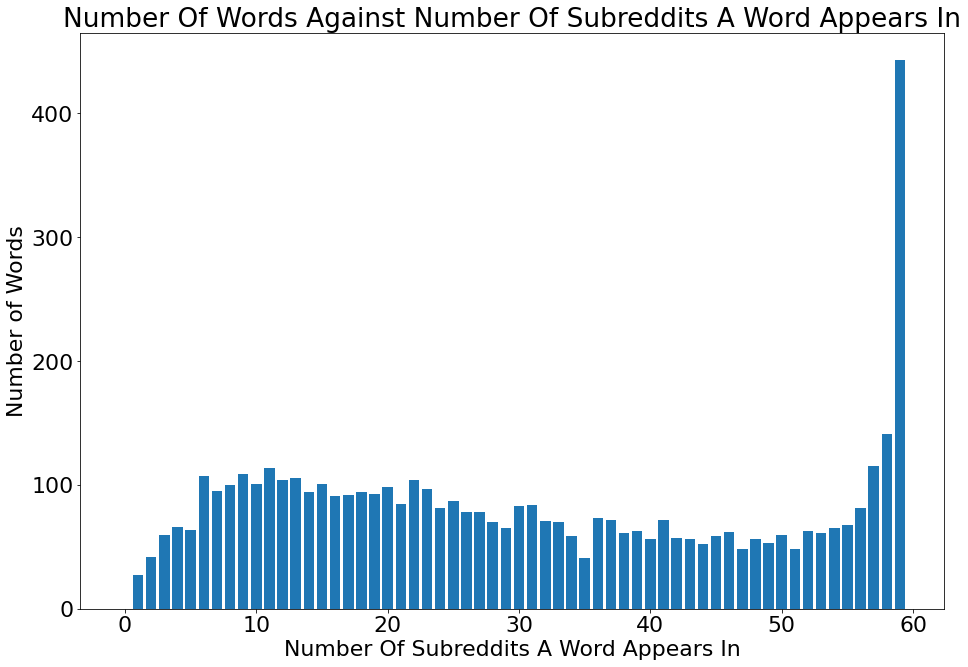

In [285]:
display_bar_chart(num_docs_per_word(wdd_tf))

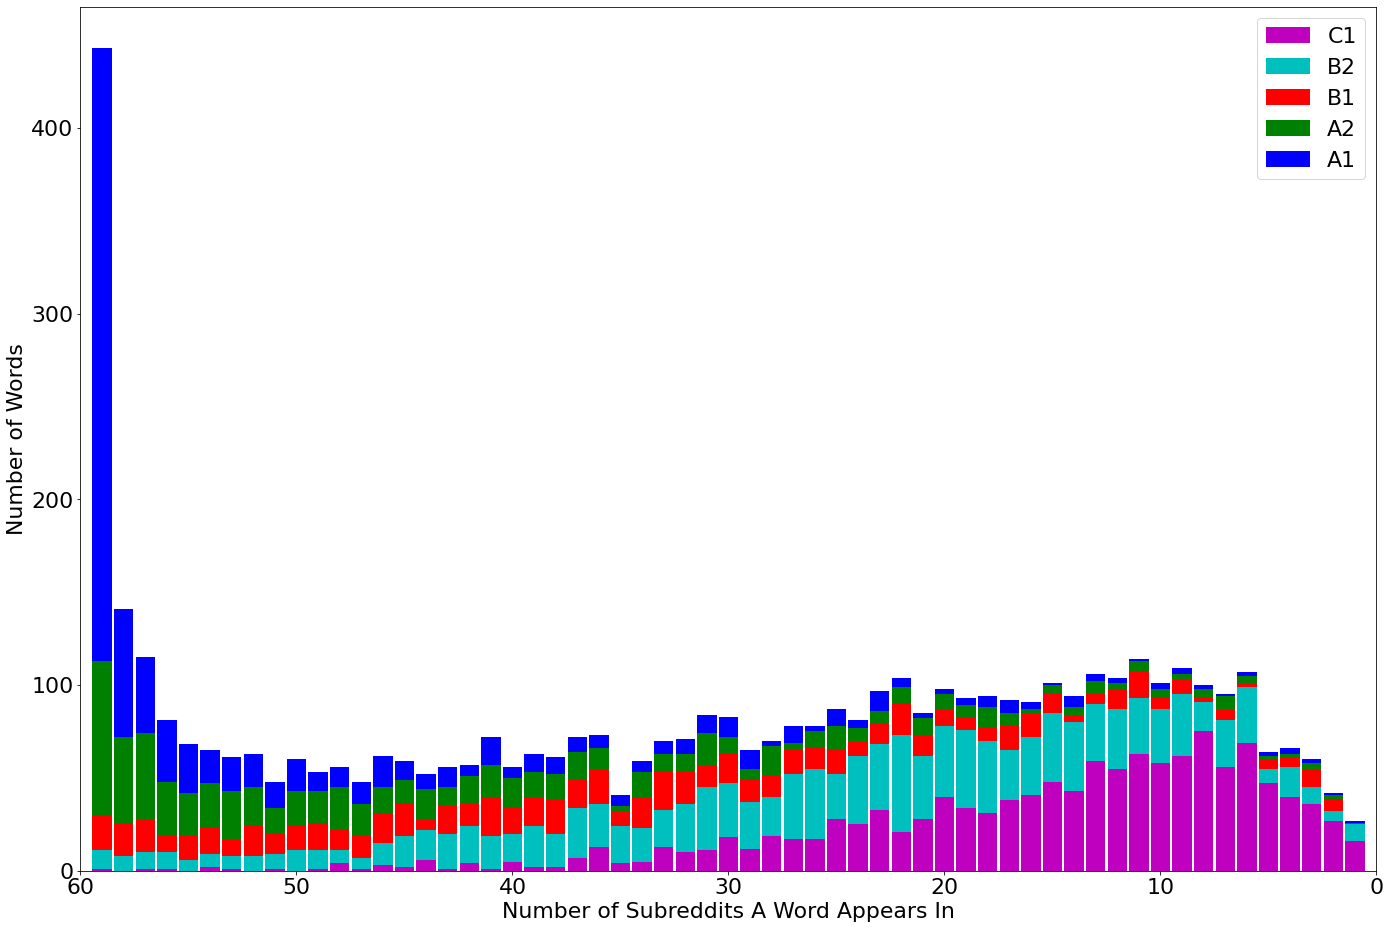

In [441]:
display_layered_bar_chart(wdd_tf)

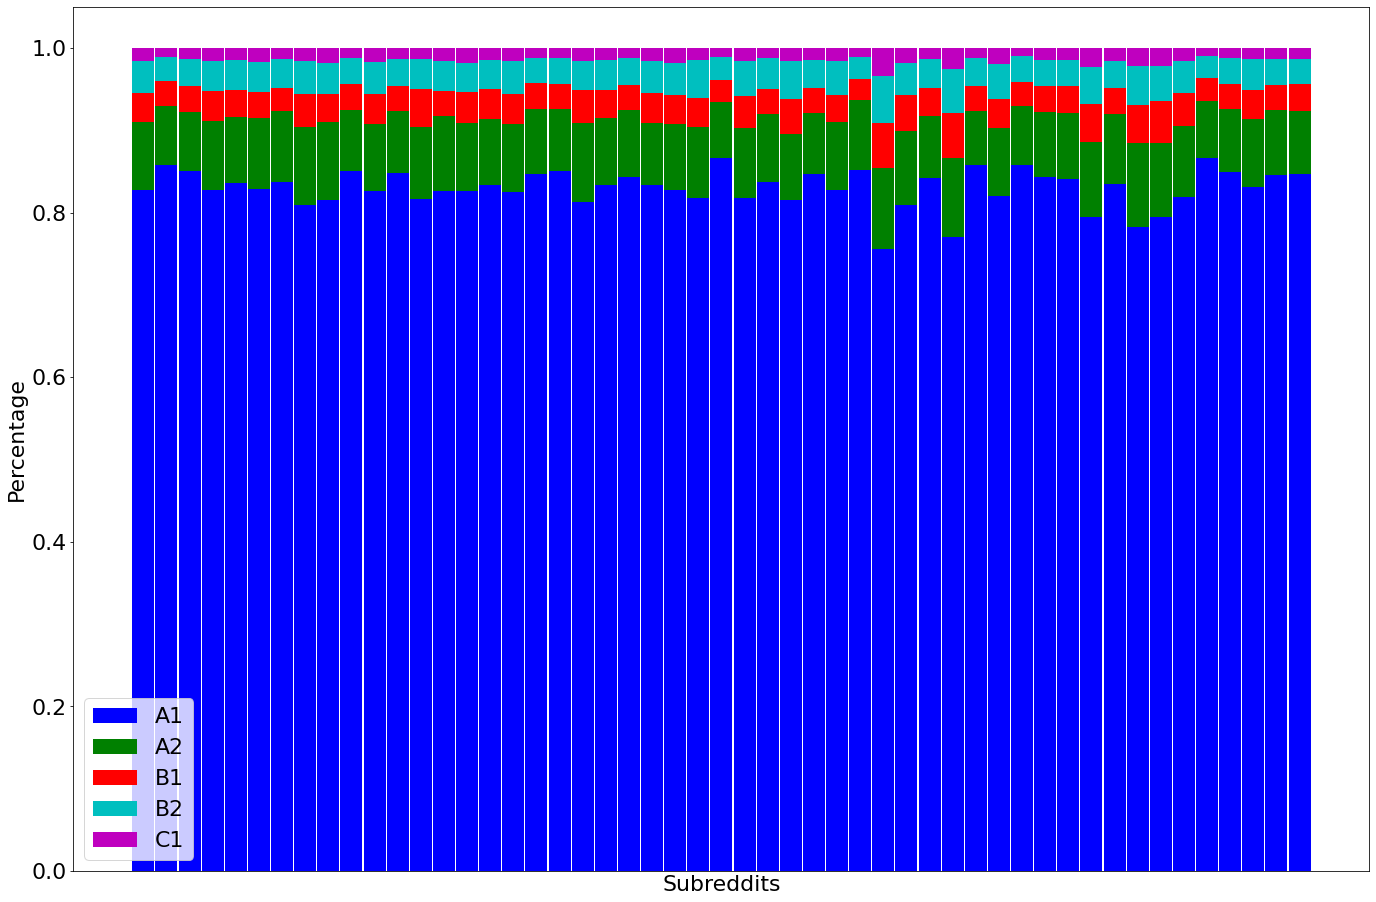

In [17]:
display_layered_frequency(num_docs_per_word(wdd_tf), wdd_feature_subset(wdd_tf, False))

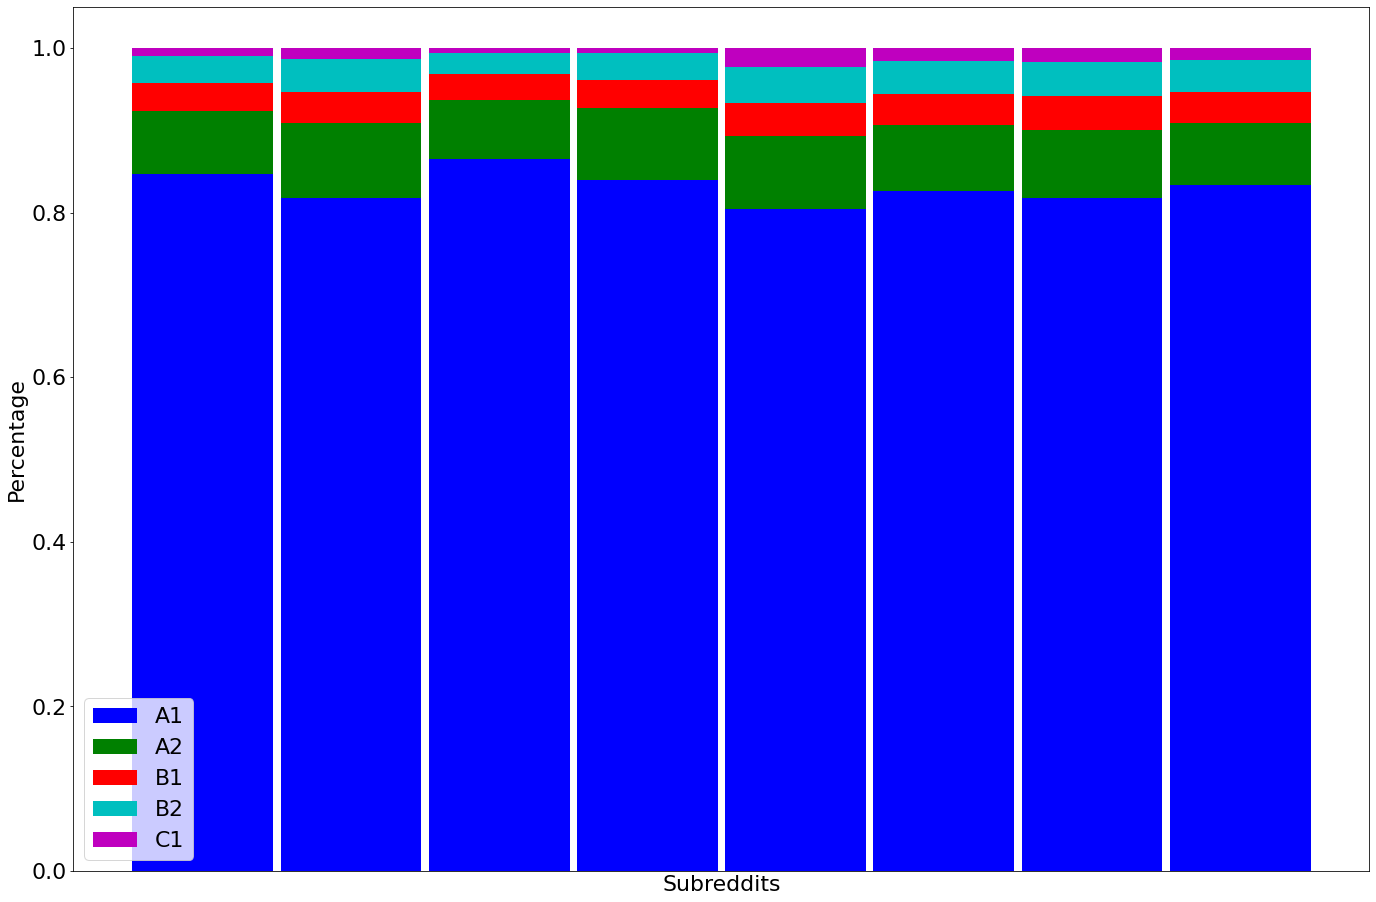

In [18]:
display_layered_frequency(num_docs_per_word(wdd_tf), wdd_feature_subset(wdd_tf, True))

# Number of Zeros in data set

In [ ]:
def percentage_of_zeros(wdd):
    data = wdd.features()
    num_zeros = np.sum(data[data == 0].count(axis=0).to_numpy())
    num_not_zeros = np.sum(data[data != 0].count(axis=0).to_numpy())
    return 100 * num_zeros / (num_zeros + num_not_zeros)

In [ ]:
print("{:30} {:.2f}".format("TF Percentage of zeros:", percentage_of_zeros(wdd_tf)))
print("{:30} {:.2f}".format("TF-IDF Percentage of zeros:", percentage_of_zeros(wdd_tf_idf)))